# This code applies a threshold to the log of the summed amplitudes across a bandpass filtered .wav file recording to detect song

### apply the full pipeline to one recording file

Screen size ≈ 15.1 × 9.8 inches
Segment 1/4: 🎵 song
Segment 2/4: 🎵 song
Segment 3/4: 🎵 song
Segment 4/4: 🎵 song


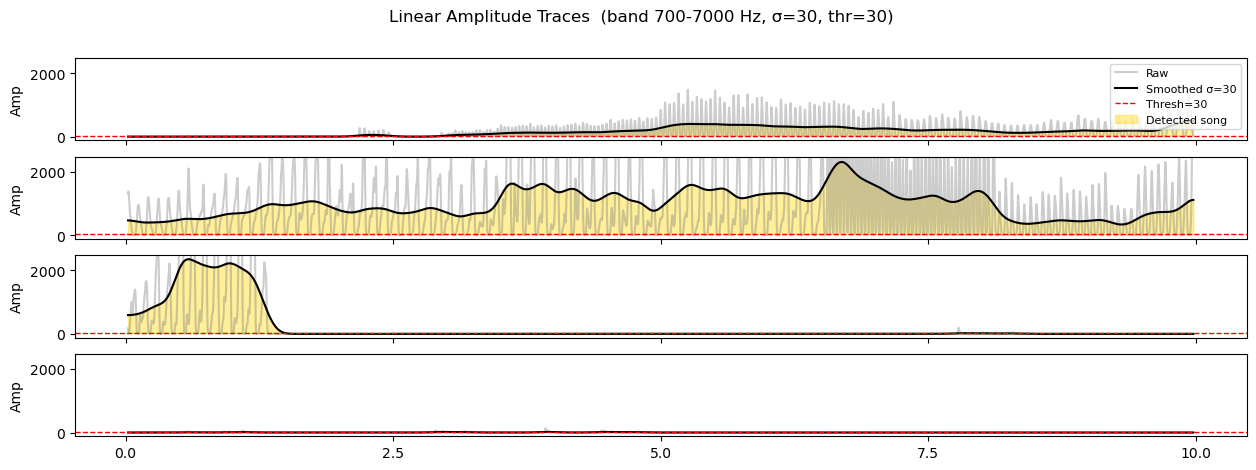

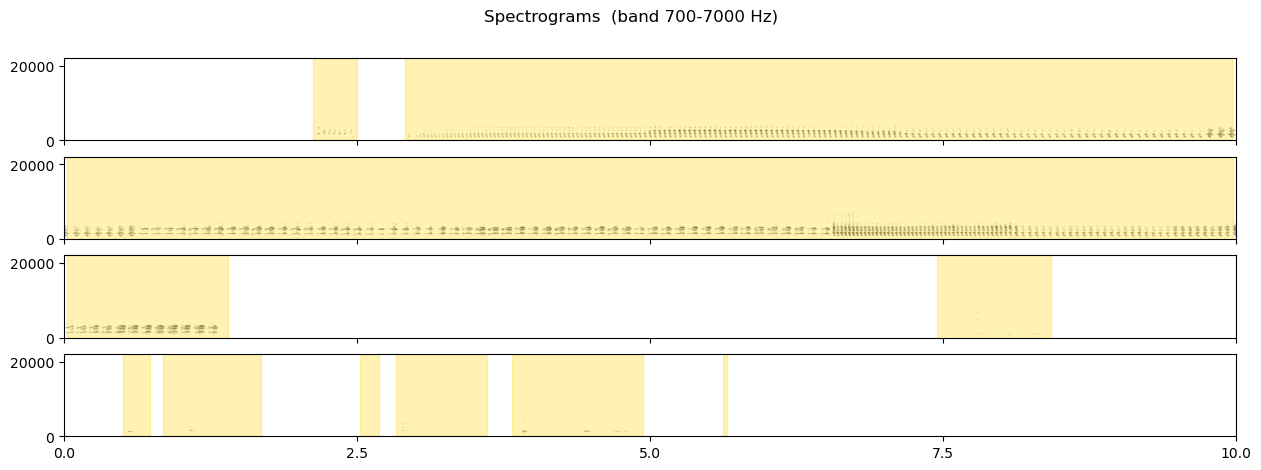

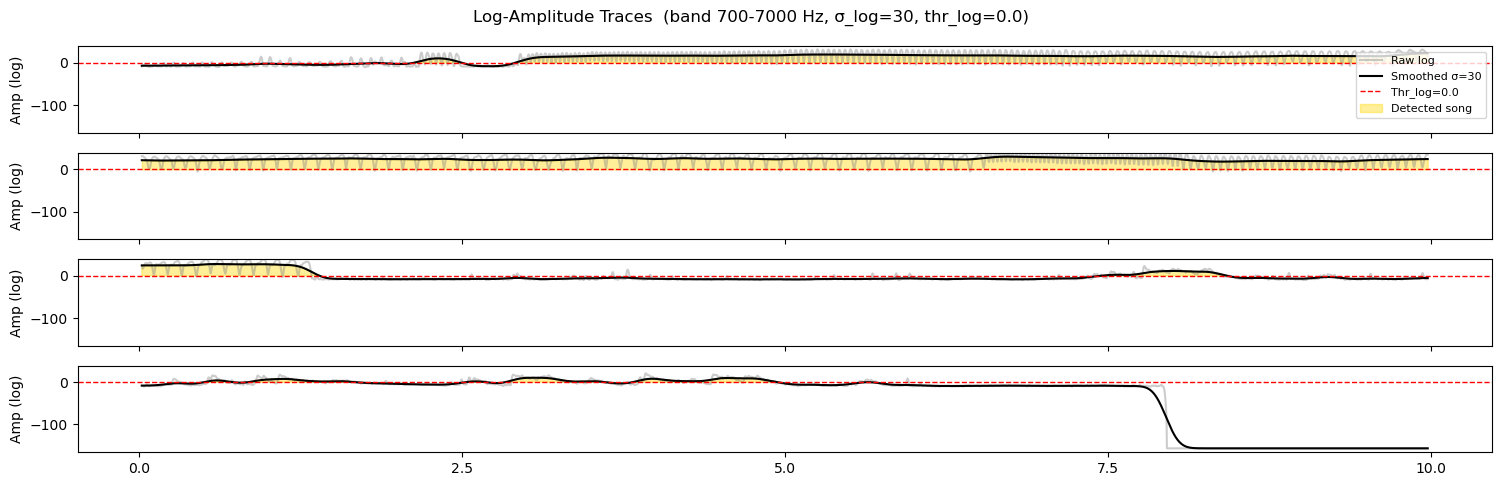

In [27]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path

# ------------------------------------------------------------
# Utility ── get screen size in inches (≈100 dpi assumption)
# ------------------------------------------------------------
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100   # inches

width_inches, height_inches = get_screen_resolution()
print(f"Screen size ≈ {width_inches:.1f} × {height_inches:.1f} inches")

# ------------------------------------------------------------
# Main visualisation routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: float = None,
        threshold_log: float = None,
        log_base: float = 10
    ):
    """
    Plot stacked amplitude traces (linear), stacked log‑amplitude traces, and
    stacked spectrograms for a WAV file. All amplitude panels share identical
    y‑axis limits in their respective domains (linear or log).

    New
    ---
    sigma_log      : σ for smoothing the log trace (defaults to `sigma`)
    threshold_log  : threshold in the *log* domain (dB if log_base=10).
    log_base       : 10  → 10*log10();  np.e  → natural log.
    """
    # ---------- defaults for log settings ----------
    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps   # avoid log(0)

    try:
        # ---------- 1. Load audio ----------
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:                      # stereo → mono
            data = data.mean(axis=1)

        # ---------- 2. Band‑pass filter ----------
        nyquist = samplerate / 2
        wp      = [bandpass_filter_low_cut / nyquist,
                   bandpass_filter_high_cut / nyquist]
        b, a    = ellip(5, 0.2, 40, wp, btype='band')
        data    = filtfilt(b, a, data)

        # ---------- 3. Segment bookkeeping ----------
        segment_len  = int(segment_duration * samplerate)
        num_segments = int(np.ceil(len(data) / segment_len))

        # ---------- 4. Prepare figure stacks ----------
        fig1, axs_amp  = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        fig2, axs_spec = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        fig3, axs_log  = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)

        if num_segments == 1:      # keep iterable
            axs_amp  = [axs_amp]
            axs_spec = [axs_spec]
            axs_log  = [axs_log]

        # global min/max holders
        gmin_lin, gmax_lin = np.inf, -np.inf
        gmin_log, gmax_log = np.inf, -np.inf

        # ---------- 5. Loop through segments ----------
        for i in range(num_segments):
            start = i * segment_len
            end   = start + segment_len
            seg   = np.zeros(segment_len, dtype=data.dtype)
            seg[:max(0, min(segment_len, len(data) - start))] = data[start:end]

            # ----- Spectrogram -----
            f, t, Sxx = spectrogram(
                seg,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )
            Sxx_log  = 10 * np.log10(Sxx + eps)
            Sxx_log  = np.clip(Sxx_log, -2, None)
            Sxx_norm = ((Sxx_log - Sxx_log.min()) /
                        (Sxx_log.max() - Sxx_log.min()))

            # ----- Amplitude trace (linear) -----
            band_rows  = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
            amp_trace  = np.sum(Sxx[band_rows, :], axis=0)
            smooth_lin = gaussian_filter1d(amp_trace, sigma=sigma)
            is_song    = smooth_lin > threshold

            # ----- Log‑amplitude trace -----
            if log_base == 10:
                amp_trace_log = 10 * np.log10(amp_trace + eps)
            else:   # natural log
                amp_trace_log = np.log(amp_trace + eps)

            smooth_log = gaussian_filter1d(amp_trace_log, sigma=sigma_log)

            # default threshold_log: set to 90th percentile of smoothed log in 1st segment
            if threshold_log is None and i == 0:
                threshold_log = np.percentile(smooth_log, 90)

            is_song_log = smooth_log > threshold_log

            # Track global min/max for unified y‑axes
            gmin_lin = min(gmin_lin, smooth_lin.min())
            gmax_lin = max(gmax_lin, smooth_lin.max())
            gmin_log = min(gmin_log, smooth_log.min())
            gmax_log = max(gmax_log, smooth_log.max())

            # ----- Plot amplitude panel (linear) -----
            ax1 = axs_amp[i]
            ax1.plot(t, amp_trace,    color='gray',  alpha=0.4, label='Raw')
            ax1.plot(t, smooth_lin,   color='black',           label=f'Smoothed σ={sigma}')
            ax1.axhline(threshold, color='red', linestyle='--', linewidth=1,
                        label=f'Thresh={threshold}')
            ax1.fill_between(t, smooth_lin, threshold, where=is_song,
                             color='gold', alpha=0.4,
                             label='Detected song' if i == 0 else None)
            ax1.set_ylabel('Amp')
            if i == 0:
                ax1.legend(fontsize=8, loc='upper right')
            ax1.set_xticks([] if i < num_segments - 1 else np.linspace(0, segment_duration, 5))

            # ----- Plot log‑amplitude panel -----
            ax3 = axs_log[i]
            ax3.plot(t, amp_trace_log, color='gray', alpha=0.4, label='Raw log')
            ax3.plot(t, smooth_log,    color='black',          label=f'Smoothed σ={sigma_log}')
            ax3.axhline(threshold_log, color='red', linestyle='--', linewidth=1,
                        label=f'Thr_log={threshold_log:.1f}')
            ax3.fill_between(t, smooth_log, threshold_log, where=is_song_log,
                             color='gold', alpha=0.4,
                             label='Detected song' if i == 0 else None)
            ax3.set_ylabel('Amp (log)')
            if i == 0:
                ax3.legend(fontsize=8, loc='upper right')
            ax3.set_xticks([] if i < num_segments - 1 else np.linspace(0, segment_duration, 5))

            # ----- Plot spectrogram panel -----
            ax2 = axs_spec[i]
            ax2.imshow(Sxx_norm, aspect='auto', origin='lower',
                       extent=[0, segment_duration, f.min(), f.max()],
                       cmap='binary')
            ax2.fill_between(t, f.min(), f.max(), where=is_song_log,
                             color='gold', alpha=0.3)
            #ax2.set_ylabel('Freq (Hz)')
            ax2.set_xticks([] if i < num_segments - 1 else np.linspace(0, segment_duration, 5))

            # Console feedback
            status = "🎵 song" if np.any(is_song_log) else "⚪ silence"
            print(f"Segment {i+1}/{num_segments}: {status}")

        # ---------- 6. Apply common y‑limits ----------
        pad_lin = 0.05 * (gmax_lin - gmin_lin or 1)
        pad_log = 0.05 * (gmax_log - gmin_log or 1)
        common_lin = (gmin_lin - pad_lin, gmax_lin + pad_lin)
        common_log = (gmin_log - pad_log, gmax_log + pad_log)
        for ax in axs_amp:
            ax.set_ylim(common_lin)
        for ax in axs_log:
            ax.set_ylim(common_log)

        # ---------- 7. Titles & layout ----------
        bp_range = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
        fig1.suptitle(f'Linear Amplitude Traces  (band {bp_range}, σ={sigma}, thr={threshold})',
                      fontsize=12)
        fig2.suptitle(f'Spectrograms  (band {bp_range})', fontsize=12)
        fig3.suptitle(f'Log‑Amplitude Traces  (band {bp_range}, σ_log={sigma_log}, '
                      f'thr_log={threshold_log:.1f})', fontsize=12)

        plt.tight_layout()
        plt.show()

    except ValueError as err:
        print(f"[ERROR] {file_path}: {err}")

# ------------------------------------------------------------
# Example call – replace with your own WAV
# ------------------------------------------------------------
if __name__ == "__main__":
    example_wav = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/USA5510_45755.25619988_4_8_7_6_59.wav")  # ⇦ change me!
    if example_wav.exists():
        plot_spectrograms_by_segment(
            file_path=str(example_wav),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=30,
            sigma_log=30,
            threshold_log=0   # dB threshold
        )
    else:
        print(f"Example WAV not found: {example_wav}")


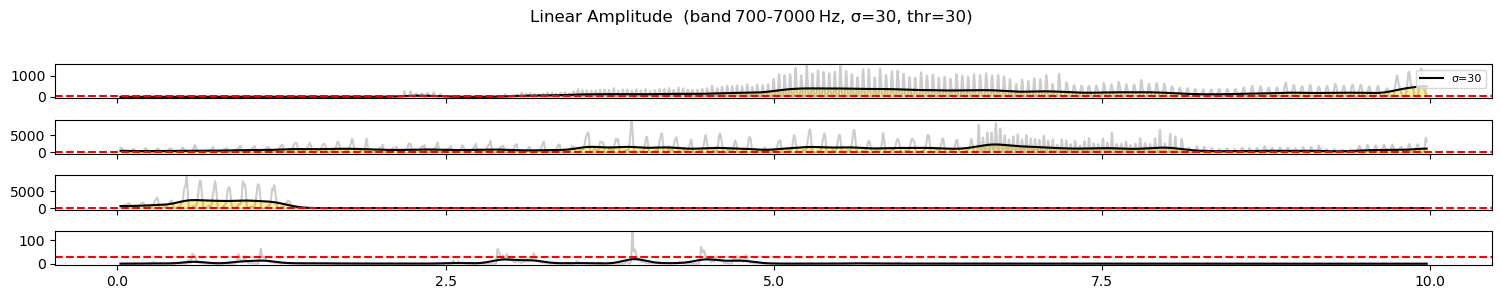

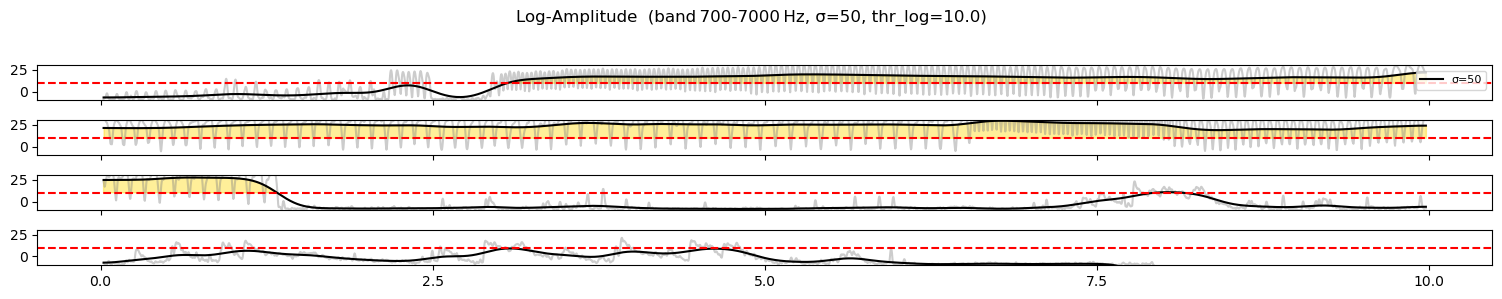

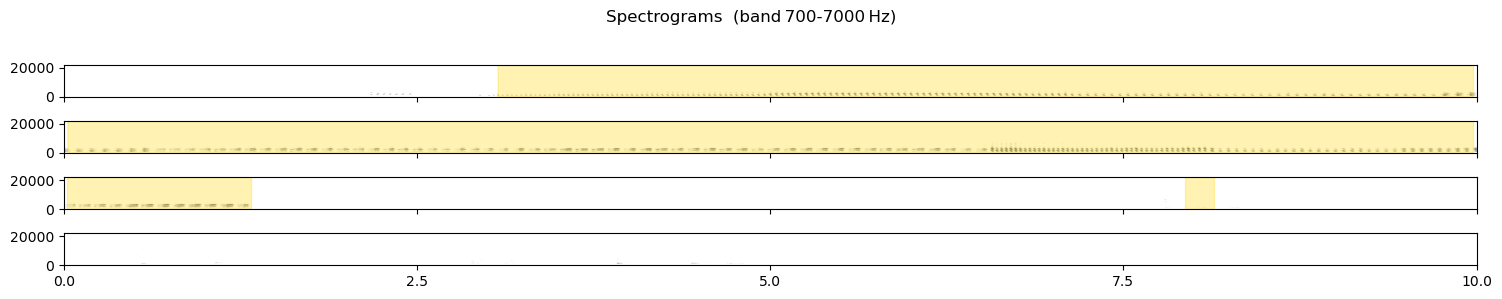


Detected song intervals (s):
      3.07 –     9.97
     10.02 –    19.97
     20.02 –    21.33
     27.93 –    28.14


In [30]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
# Utility – get screen size (~100 dpi assumption)
# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
# Helper – mask → contiguous (start,end) intervals (s)
# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
# Main routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:
    """Plot linear amp, log‑amp, spectrogram; return detected song intervals."""
    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    # ---------- 1 · Load ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # ---------- 2 · Band‑pass filter ----------
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- 3 · Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- 4 · Figure stacks ----------
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3), sharex=True)
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3), sharex=True)
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3), sharex=True)
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- 5 · Per‑segment processing ----------
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        # Log amplitude
        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)
        mask_log = amp_log_s > threshold_log

        # Detected intervals
        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Plot linear amp ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4)
        axL.plot(t, amp_s, color='black', label=f'σ={sigma}')
        axL.axhline(threshold, color='red', ls='--')
        axL.fill_between(t, amp_s, threshold, where=mask_lin, color='gold', alpha=0.4)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=8, loc='upper right')

        # ---- Plot log amp ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4)
        axLg.plot(t, amp_log_s, color='black', label=f'σ={sigma_log}')
        axLg.axhline(threshold_log, color='red', ls='--')
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log, color='gold', alpha=0.4)
        axLg.set_ylim(-10, 30)                       # fixed range
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=8, loc='upper right')

        # ---- Plot spectrogram ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- 6 · Figure titles & layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3):
        fig.tight_layout(rect=[0, 0, 1, 0.95])   # leave room for suptitle

    plt.show()

    # ---------- 7 · Print & return intervals ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=30,
            sigma_log=50,
            threshold_log=10     # dB
        )
    else:
        print("Example WAV not found:", wav_path)


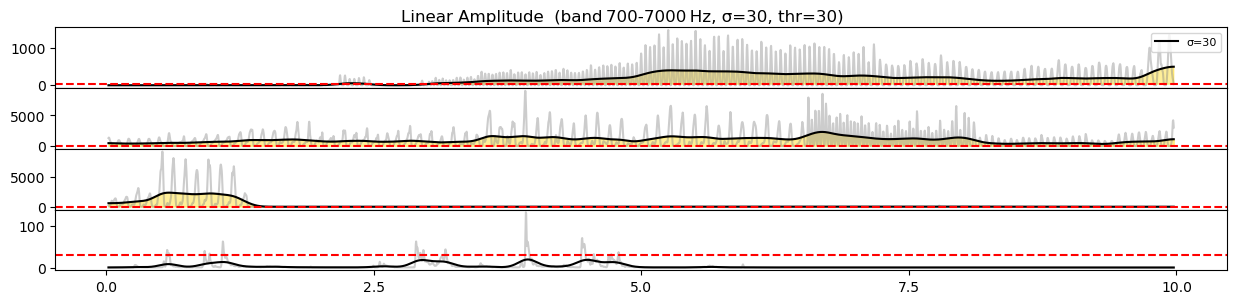

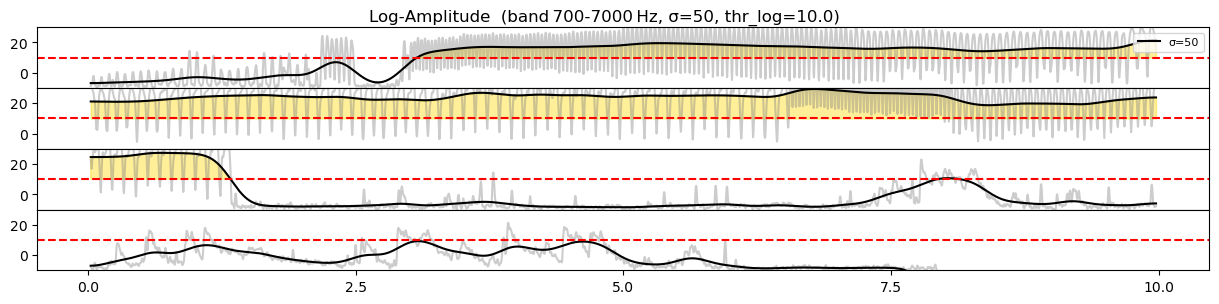

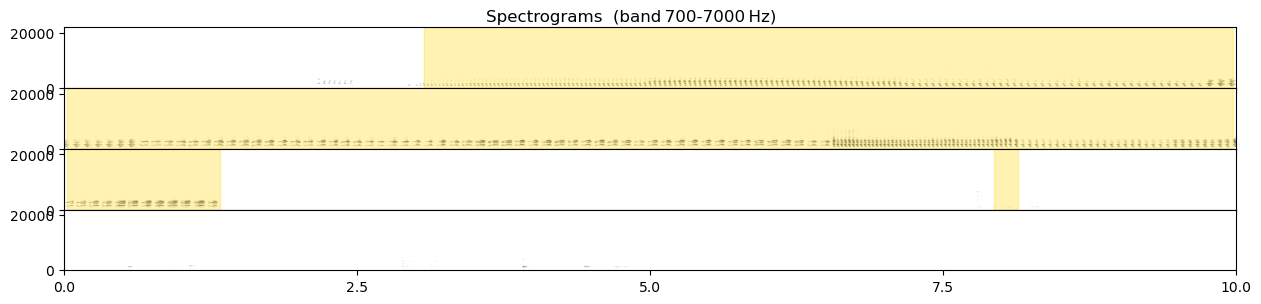


Detected song intervals (s):
      3.07 –     9.97
     10.02 –    19.97
     20.02 –    21.33
     27.93 –    28.14


In [32]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
# Utility – get screen size (~100 dpi assumption)
# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
# Helper – mask → contiguous (start,end) intervals (s)
# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
# Main routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:
    """Plot linear amp, log‑amp, spectrogram; return detected song intervals."""
    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    # ---------- 1 · Load ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # ---------- 2 · Band‑pass filter ----------
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- 3 · Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- 4 · Figure stacks (no vertical spacing) ----------
    fig1, axs_lin = plt.subplots(
        n_seg, 1, figsize=(width_inches, 3),
        sharex=True, gridspec_kw={"hspace": 0}
    )
    fig2, axs_log = plt.subplots(
        n_seg, 1, figsize=(width_inches, 3),
        sharex=True, gridspec_kw={"hspace": 0}
    )
    fig3, axs_spc = plt.subplots(
        n_seg, 1, figsize=(width_inches, 3),
        sharex=True, gridspec_kw={"hspace": 0}
    )
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- 5 · Per‑segment processing ----------
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        # Log amplitude
        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)
        mask_log = amp_log_s > threshold_log

        # Detected intervals
        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Plot linear amp ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4)
        axL.plot(t, amp_s, color='black', label=f'σ={sigma}')
        axL.axhline(threshold, color='red', ls='--')
        axL.fill_between(t, amp_s, threshold, where=mask_lin, color='gold', alpha=0.4)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=8, loc='upper right')

        # ---- Plot log amp ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4)
        axLg.plot(t, amp_log_s, color='black', label=f'σ={sigma_log}')
        axLg.axhline(threshold_log, color='red', ls='--')
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log, color='gold', alpha=0.4)
        axLg.set_ylim(-10, 30)                       # fixed range
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=8, loc='upper right')

        # ---- Plot spectrogram ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- 6 · Figure titles & layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92)   # zero gap; space for title

    plt.show()

    # ---------- 7 · Print & return intervals ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=30,
            sigma_log=50,
            threshold_log=10     # dB
        )
    else:
        print("Example WAV not found:", wav_path)


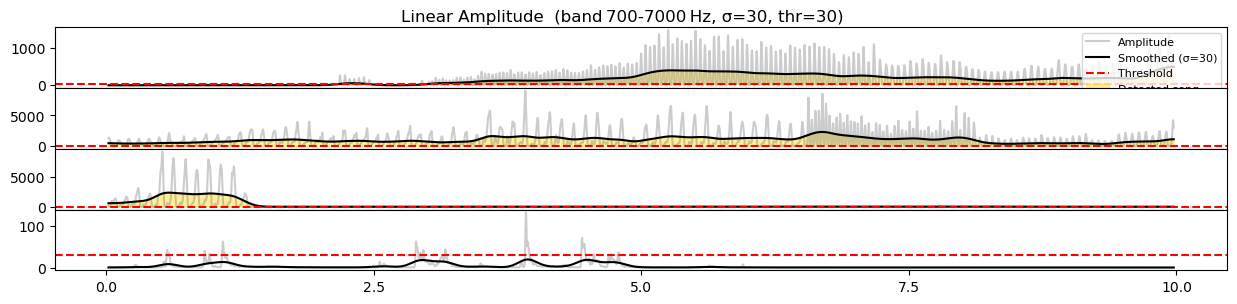

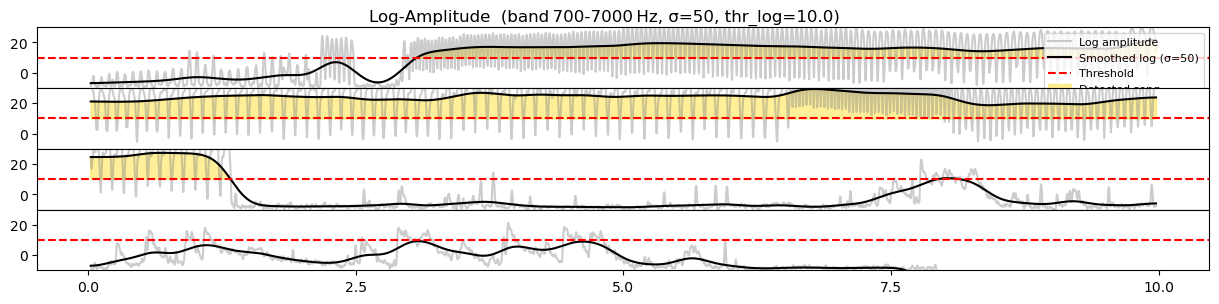

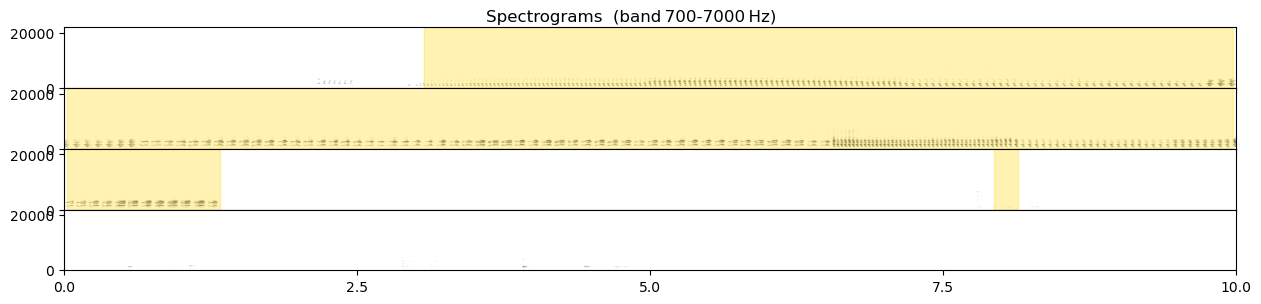


Detected song intervals (s):
      3.07 –     9.97
     10.02 –    19.97
     20.02 –    21.33
     27.93 –    28.14


In [38]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:

    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    fig1, axs_lin = plt.subplots(
        n_seg, 1, figsize=(width_inches, 3),
        sharex=True, gridspec_kw={"hspace": 0}
    )
    fig2, axs_log = plt.subplots(
        n_seg, 1, figsize=(width_inches, 3),
        sharex=True, gridspec_kw={"hspace": 0}
    )
    fig3, axs_spc = plt.subplots(
        n_seg, 1, figsize=(width_inches, 3),
        sharex=True, gridspec_kw={"hspace": 0}
    )
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)
        mask_log = amp_log_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Linear amplitude plot ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s, color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=8, loc='upper right')

        # ---- Log amplitude plot ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.plot(t, amp_log_s, color='black',
                  label=f'Smoothed log (σ={sigma_log})' if i == 0 else None)
        axLg.axhline(threshold_log, color='red', ls='--',
                     label='Threshold' if i == 0 else None)
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log,
                          color='gold', alpha=0.4,
                          label='Detected song' if i == 0 else None)
        axLg.set_ylim(-10, 30)
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=8, loc='upper right')

        # ---- Spectrogram plot ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=30,
            sigma_log=50,
            threshold_log=10     # dB
        )
    else:
        print("Example WAV not found:", wav_path)


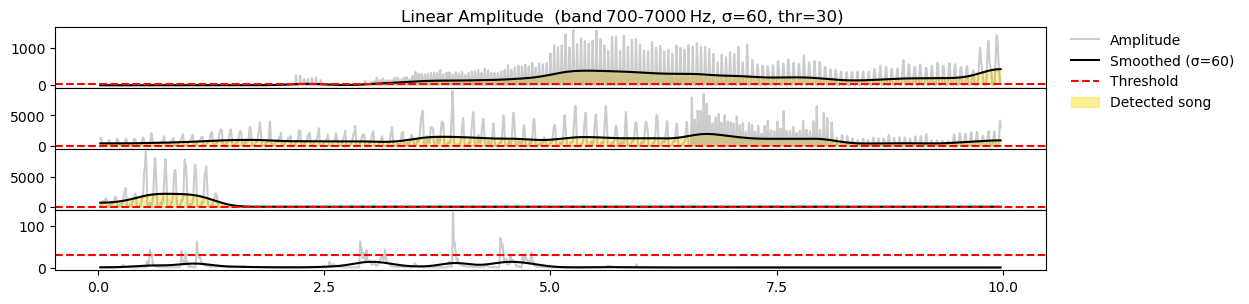

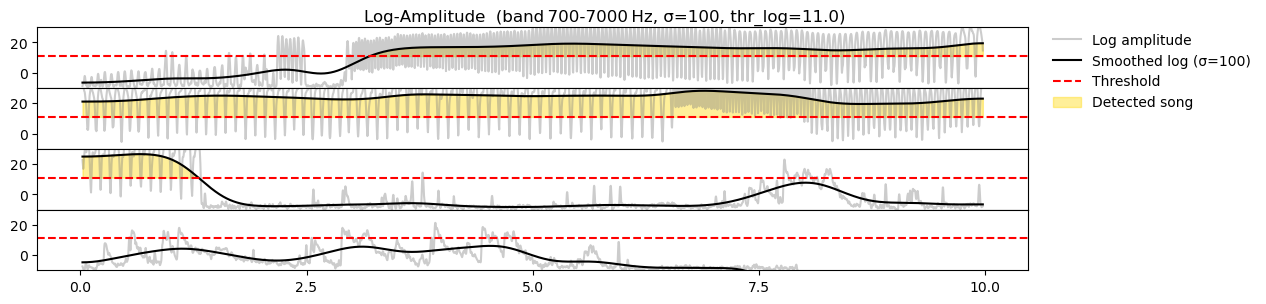

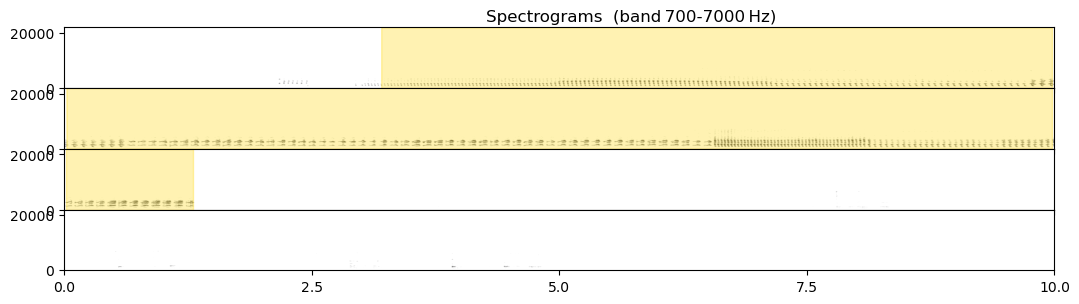


Detected song intervals (s):
      3.20 –     9.97
     10.02 –    19.97
     20.02 –    21.30


In [45]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:

    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    # ---------- Load & band‑pass filter ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- Figure stacks (no vertical spacing) ----------
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- Per‑segment processing ----------
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear & log amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)
        mask_log = amp_log_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Linear amplitude plot ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s, color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Log amplitude plot ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.plot(t, amp_log_s, color='black',
                  label=f'Smoothed log (σ={sigma_log})' if i == 0 else None)
        axLg.axhline(threshold_log, color='red', ls='--',
                     label='Threshold' if i == 0 else None)
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log,
                          color='gold', alpha=0.4,
                          label='Detected song' if i == 0 else None)
        axLg.set_ylim(-10, 30)
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Spectrogram plot ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & final layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)  # room for legends

    plt.show()

    # ---------- Console output ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=60,
            threshold=30,
            sigma_log=100,
            threshold_log=11     # dB
        )
    else:
        print("Example WAV not found:", wav_path)
